# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

<b> Data Problem Definition</b><br/>

We need to devise a machine learning model to predict used car prices. We should also identify  features of different types of automobiles that affect its sale price. In order to accomplish this task, we have been given used car sales data from 1900 to 2022. We are going to use multiple prediction techniques to model the used car sales data in order to predict sale prices in future

For our modeling purposes, I am going to consider only about the last 20 years of data as car prices earlier than that may not affect used car prices today due to different economic conditions.

Based on the modeling, we should identify car features valued by customers.

In [1]:
#Inlcude this line to show plots from included python files
%matplotlib inline 

In [2]:
import datetime
import statsmodels.api as sm
from warnings import filterwarnings 
filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import category_encoders as ce
from category_encoders import JamesSteinEncoder

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer, make_column_selector

import prac2app_utils
from tabulate import tabulate

In [3]:
#include the current working drectory to the Python Path to include modules
import sys
sys.path.append('.') # Adds the current directory to Python path

In [4]:
orig_df = pd.read_csv("data/vehicles.csv")

In [5]:
orig_df.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

Used car sales data contains the following information <br/>

<b>id</b> - recordid <br/>
<b>region</b> - US region where the car sales occurred<br/>
<b>price</b> - sale price of the car<br/>
<b>year</b> - year of manufacture<br/>
<b>manufacturer</b> - car brand<br/>
<b>model</b> - car model<br/>
<b>condition</b> - car condition<br/>
<b>cylinders</b> - number of cylinders in the car<br/>
<b>fuel</b> - fuel type used by the car<br/>
<b>odometer</b> - number of miles driven by the car<br/>
<b>title_status</b> - status of the car title<br/>
<b>transmission</b> - transmission type of the car<br/>
<b>VIN</b> - VIN number of the car<br/>
<b>drive</b> - drive train for the car<br/>
<b>size</b>  - size of the car<br/>
<b>type</b> - type of the car<br/>
<b>paint_color</b> - color of the car<br/>
<b>state</b> - state where the car was registered<br/>


<b>id</b> and <b>VIN</b> are row and car identifiers respectively. These two variables don't affect the sale price.<br/>
<b>region</b>, <b>manufacturer</b>, <b>model</b>, <b>condition</b>, <b>cylinders</b>, <b>fuel</b>, <b>odometer</b>, <b>title_status</b>,<b>transmission</b>, <b>drive</b>, <b>size</b>, <b>type</b>, <b>paint_color</b> and <b>state</b> are categorical variables.
<br/>

I am going to calculate the age of the car to understand its impact on the model.

Target variable for our modeling is <b>price</b>

<b>Exception</b> :  I am <b>not</b> using <b>'model'</b> as one of the features due to the amount of computation needed for processing this column. This is done due to practical reasons as including it in feature independence tests,encoding  and modeling results in this notebook hanging for a long time.

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 


#### Data Preparation Steps
1. Filter out data before 2004  and copy it to a new DataFrame. Data before 2004 may not be relevant due to different economic conditions.<br/>
2. Calculate age of the car and add it to the DataFrame
3. Handle NULL Data <br/>
4. Drop unwanted columns
5. Ensure that the target and odometer columns contain non zero values.
6. Replace null values or missing values with appropirate values for remaining columns.
7. Analyze  the target variable <b>price</b> and  continuous variables odometer & age to remove outliers.
8. Feature independence test for categorical variables

#### Manual Feature Selection
1. Skip fuel as 84% of entries use gas fuelled vehicle
2. Skip transmission as 78% of the vehicle is automatic.
3. Skip cylinder as this info can be reasonably deduced from the type of vehicle

Typically,  car buyers look at the <b>combination</b> of manufacturer, condition, type, drive, odometer and the age of the car for making decisions about buying a car. State is also a factor as taxes and  dealer fees are different for different states.

#### Encode categorical features using James Stein Encoding

I am using the James Stein encoder to ensure that the number of features are manageable. Column transformers are used in the Modeling section to use JamesStein encoder to encode categorical variables.
 


#### Look only at data only on/after 2004 to ensure that we are are not considering data from years with different economic conditions. 

In [6]:
#Look at past 20 years of data to get recent insights
df = orig_df[orig_df['year'] >= 2004]
df['age']  = datetime.datetime.now().year-df['year']

In [7]:
#Convert columns to appropriate datatypes
df = df.convert_dtypes()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 379672 entries, 27 to 426879
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            379672 non-null  Int64 
 1   region        379672 non-null  string
 2   price         379672 non-null  Int64 
 3   year          379672 non-null  Int64 
 4   manufacturer  367757 non-null  string
 5   model         376427 non-null  string
 6   condition     220218 non-null  string
 7   cylinders     215832 non-null  string
 8   fuel          377052 non-null  string
 9   odometer      375556 non-null  Int64 
 10  title_status  372101 non-null  string
 11  transmission  377310 non-null  string
 12  VIN           253031 non-null  string
 13  drive         263677 non-null  string
 14  size          101096 non-null  string
 15  type          302837 non-null  string
 16  paint_color   265107 non-null  string
 17  state         379672 non-null  string
 18  age           379672 non-nul

#### Handle Null data
1. Remove rows of columns that contribute to less than 5% of null data
2. Remove those columns with null values for majority of the rows
3. Drop those columns that doesn't affect sale price  (VIN)

In [8]:
# Check for null data and also print percent of rows that contain the null data
null_list = df.isnull().sum()
cols_with_lt_five_pct_null = []
for col, null_count in null_list.items():
    if(null_count > 0):
        percent_null_rows = 100*null_count/df.shape[0]
        print(col,null_count, f"{percent_null_rows:0.2f}%") 
        if(percent_null_rows < 5):
            cols_with_lt_five_pct_null.append(col)
print("Columns with less than 5% null values:" , cols_with_lt_five_pct_null)


manufacturer 11915 3.14%
model 3245 0.85%
condition 159454 42.00%
cylinders 163840 43.15%
fuel 2620 0.69%
odometer 4116 1.08%
title_status 7571 1.99%
transmission 2362 0.62%
VIN 126641 33.36%
drive 115995 30.55%
size 278576 73.37%
type 76835 20.24%
paint_color 114565 30.17%
Columns with less than 5% null values: ['manufacturer', 'model', 'fuel', 'odometer', 'title_status', 'transmission']


In [9]:
old_row_count = df.shape[0]
#dropping rows that contributes to less than 5% of null values for its columns.

df.dropna(subset = cols_with_lt_five_pct_null, axis=0, inplace=True)

#### Drop unwanted columns

In [10]:
#dropping columns which contains more than 50% null values
df = df.drop(['size'], axis=1)

#VIN number doesn't contribute to the sale price

df = df.drop(['VIN'], axis=1)

#region is not well defined as it contains city or state or both. So dropping that column as we have a state column.
df = df.drop(['region'], axis=1)

#since 96% of rows have clean title, we can drop this column as this column is not useful for our analysis
df = df.drop(['title_status'], axis=1)

# Dropping the model column as due to the amount of computation needed for processing this column. 
# This is done due to practical reasons as including it in feature independence tests,encoding and 
# modeling results in this  notebook hanging for a long time.


df = df.drop(['model'], axis=1)

new_row_count = df.shape[0]
percent_dropped_rows = (old_row_count-new_row_count)/old_row_count

print("New Row count:", new_row_count, "percent of dropped rows:",  f"{percent_dropped_rows*100:0.2f}%" )



New Row count: 350757 percent of dropped rows: 7.62%


In [11]:
# for remaining categorical variables, fill null values with a new category called 'unknown'
null_col_ct = df.isnull().sum()

for index, value in null_col_ct.items():
    if(value > 0):
        percent_null_val = 100*(value/df.shape[0])
        df[index].fillna('unknown', inplace=True)
        print("Unique values for the column \033[1m", index, "\033[0m with null value percent of \033[1m", 
              f'{percent_null_val:0.2f}', " \033[0m is ", df[index].unique())

Unique values for the column  condition  with null value percent of  41.69   is  <StringArray>
['good', 'excellent', 'fair', 'like new', 'unknown', 'new', 'salvage']
Length: 7, dtype: string
Unique values for the column  cylinders  with null value percent of  42.86   is  <StringArray>
[ '8 cylinders',  '6 cylinders',      'unknown',  '4 cylinders',
  '5 cylinders', '10 cylinders',        'other',  '3 cylinders',
 '12 cylinders']
Length: 9, dtype: string
Unique values for the column  drive  with null value percent of  29.59   is  <StringArray>
['unknown', 'rwd', '4wd', 'fwd']
Length: 4, dtype: string
Unique values for the column  type  with null value percent of  19.88   is  <StringArray>
[     'pickup',       'truck',       'other',       'coupe',         'SUV',
   'hatchback',    'mini-van',       'sedan',     'offroad',         'van',
 'convertible',     'unknown',       'wagon',         'bus']
Length: 14, dtype: string
Unique values for the column  paint_color  with null value perce

#### Ensure that the target and odometer columns contain non zero values

In [12]:
#price and odometer cannot be zero. So dropping those rows
orig_row_count = df.shape[0]
df = df[(df['price'] > 0) & (df['odometer'] > 0)]
if(orig_row_count - df.shape[0] > 0):
    percent_rows_removed = (orig_row_count - df.shape[0])/orig_row_count
    print(orig_row_count - df.shape[0], '(', f'{percent_rows_removed: 0.2f}', ')', ' rows were removed to ensure that price and odometer had non zero values')


28146 (  0.08 )  rows were removed to ensure that price and odometer had non zero values


In [13]:
df.head()

,id,price,year,manufacturer,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color,state,age
27,7316814884,33590,2014,gmc,good,8 cylinders,gas,57923,other,unknown,pickup,white,al,11
28,7316814758,22590,2010,chevrolet,good,8 cylinders,gas,71229,other,unknown,pickup,blue,al,15
29,7316814989,39590,2020,chevrolet,good,8 cylinders,gas,19160,other,unknown,pickup,red,al,5
30,7316743432,30990,2017,toyota,good,8 cylinders,gas,41124,other,unknown,pickup,red,al,8
31,7316356412,15000,2013,ford,excellent,6 cylinders,gas,128000,automatic,rwd,truck,black,al,12


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 322611 entries, 27 to 426879
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            322611 non-null  Int64 
 1   price         322611 non-null  Int64 
 2   year          322611 non-null  Int64 
 3   manufacturer  322611 non-null  string
 4   condition     322611 non-null  string
 5   cylinders     322611 non-null  string
 6   fuel          322611 non-null  string
 7   odometer      322611 non-null  Int64 
 8   transmission  322611 non-null  string
 9   drive         322611 non-null  string
 10  type          322611 non-null  string
 11  paint_color   322611 non-null  string
 12  state         322611 non-null  string
 13  age           322611 non-null  Int64 
dtypes: Int64(5), string(9)
memory usage: 38.5 MB


####  Remove outliers for price

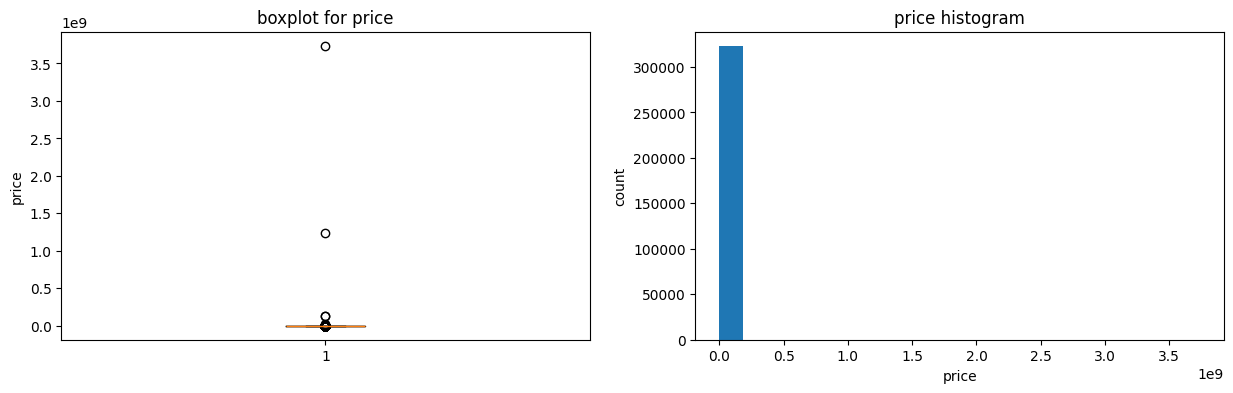

In [15]:
#plots to check outliers for price
prac2app_utils.subplot_box_hist(df, 'price', 'boxplot for price', 'price histogram')

<b>boxplot indicates that there are outliers for price </b>

In [16]:

#remove outliers for price using IQR and also optimize the number of outliers by setting the appropriate outlier threshold 
price_outliers = prac2app_utils.analyze_outliers(df, 'price', 2.5 )
price_outliers.sort_values(by='price', ascending=False).head(10)


 Outlier Row Count: 928  Outlier Row Percent: 0.28765293185911206 %
 Outlier Max: 3736928711  Outlier Median: 89990.0  Outlier Mean: 5773851.982758621  Outlier Min: 80337


,id,price,year,manufacturer,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color,state,age
318592,7308056031,3736928711,2007,toyota,excellent,8 cylinders,gas,164000,automatic,4wd,pickup,silver,or,18
153082,7305153975,1234567890,2006,volvo,fair,unknown,other,200000,manual,unknown,unknown,black,in,19
230753,7308010868,135008900,2008,nissan,like new,8 cylinders,gas,110500,automatic,4wd,truck,grey,nc,17
193736,7315524207,123456789,2015,chevrolet,like new,unknown,gas,64181,automatic,fwd,sedan,red,mi,10
136516,7316047597,17000000,2007,ram,good,8 cylinders,diesel,170000,automatic,4wd,pickup,black,id,18
105843,7314124996,6995495,2014,dodge,unknown,4 cylinders,gas,135888,automatic,fwd,SUV,unknown,fl,11
155421,7308748768,1234567,2006,jeep,like new,6 cylinders,gas,123456,automatic,4wd,SUV,custom,in,19
194292,7307876060,1234567,2010,lincoln,like new,unknown,gas,85653,automatic,unknown,SUV,custom,mi,15
232829,7313752706,1000000,2016,ford,unknown,unknown,gas,100000,automatic,unknown,unknown,unknown,nc,9
233823,7310495996,1000000,2016,ford,unknown,unknown,gas,100000,automatic,unknown,unknown,unknown,nc,9


In [17]:
#remove outliers for price
df = df.drop(price_outliers.index)

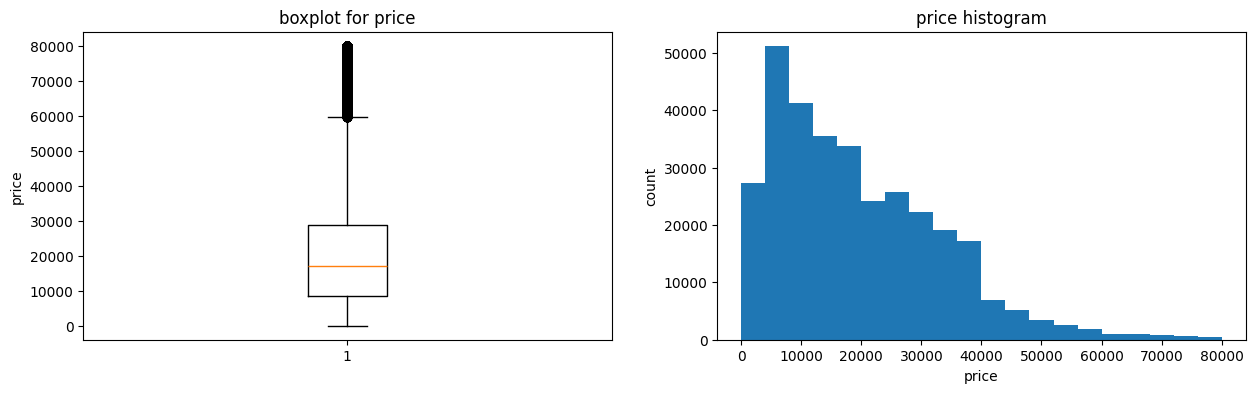

In [18]:
#plots after price outliers are removed
prac2app_utils.subplot_box_hist(df, 'price', 'boxplot for price', 'price histogram')

<b>Removing outliers leads to a a better distribution and histogram for price </b>

####  Check for outliers for Odometer

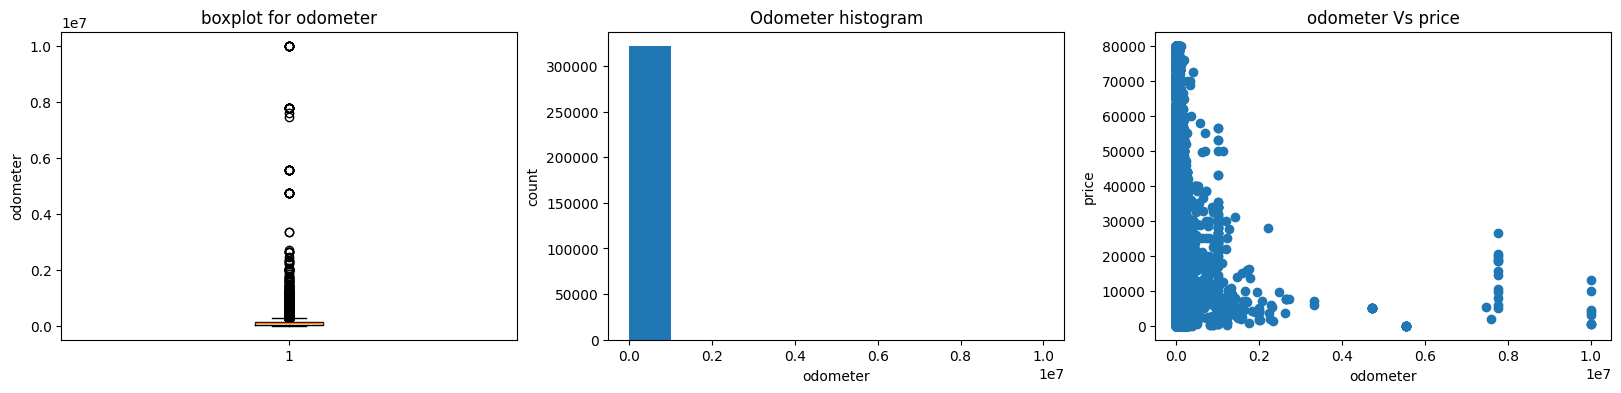

In [19]:
#plots to check outliers for odometer
prac2app_utils.subplot_box_hist_scatter(df, 'odometer', 'price', 'boxplot for odometer', 'Odometer histogram', 'odometer Vs price')

<b> These plots indicate that there are outliers for odometer </b>

In [20]:
#remove outliers for odometer using IQR and also minimize the number of outliers by setting the appropriate outlier threshold 

odometer_outliers = prac2app_utils.analyze_outliers(df, 'odometer', 4.5)
odometer_outliers.sort_values(by='odometer', ascending=False).tail(10)

 Outlier Row Count: 307  Outlier Row Percent: 0.09543556855662251 %
 Outlier Max: 10000000  Outlier Median: 999999.0  Outlier Mean: 1911994.8957654722  Outlier Min: 552000


,id,price,year,manufacturer,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color,state,age
75233,7302843031,10995,2015,fiat,unknown,4 cylinders,gas,636200,automatic,fwd,hatchback,custom,co,10
140082,7316835428,21000,2012,volvo,excellent,unknown,diesel,631000,manual,unknown,truck,white,il,13
121243,7316938034,49500,2015,volvo,good,unknown,diesel,627069,automatic,unknown,other,unknown,ga,10
164471,7316353978,16950,2012,volvo,good,unknown,diesel,626000,automatic,rwd,unknown,white,ks,13
260807,7312921542,25000,2014,volvo,unknown,unknown,diesel,613000,manual,unknown,unknown,unknown,nm,11
65611,7309051490,2500,2022,honda,fair,4 cylinders,gas,605000,manual,unknown,unknown,unknown,ca,3
415173,7314245738,28750,2015,volvo,good,6 cylinders,diesel,586692,manual,rwd,truck,white,wi,10
26153,7314868317,58000,2016,volvo,unknown,unknown,diesel,578000,automatic,unknown,unknown,unknown,ca,9
351113,7310135821,35000,2015,volvo,excellent,6 cylinders,diesel,554000,manual,unknown,unknown,red,sd,10
419164,7315852601,5650,2007,chevrolet,unknown,8 cylinders,gas,552000,automatic,4wd,unknown,unknown,wi,18


In [21]:
#drop outliers for odometer
df = df.drop(odometer_outliers.index)

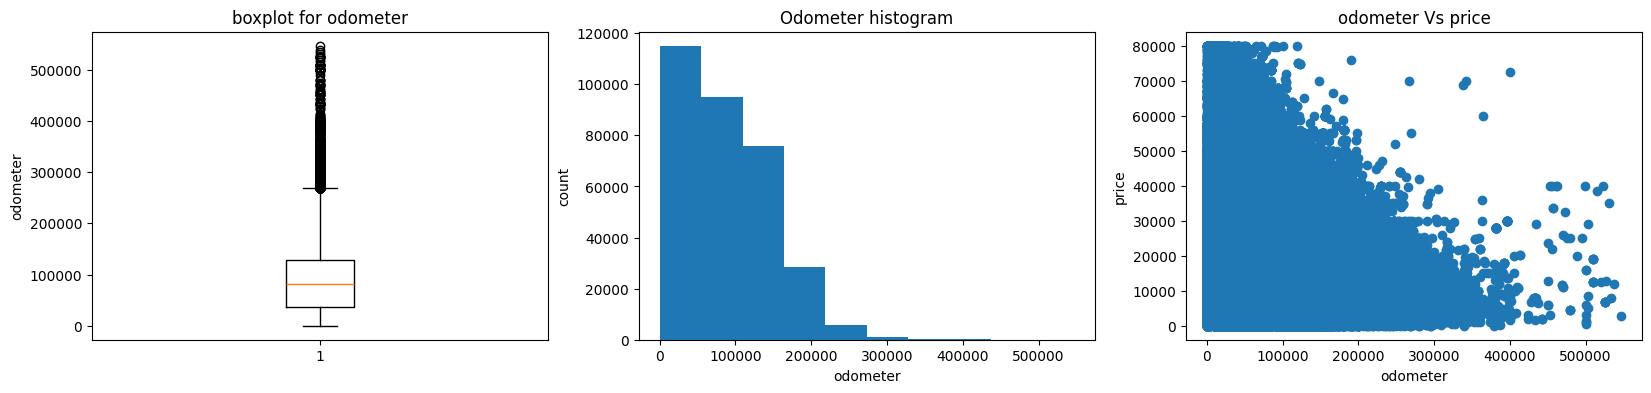

In [22]:
#plot after odometer outliers are removed
prac2app_utils.subplot_box_hist_scatter(df, 'odometer', 'price', 'boxplot for odometer', 'Odometer histogram', 'odometer Vs price')

<b>Removing outliers leads to a a better distribution and histogram for odometer </b>

####  Check for outliers for age

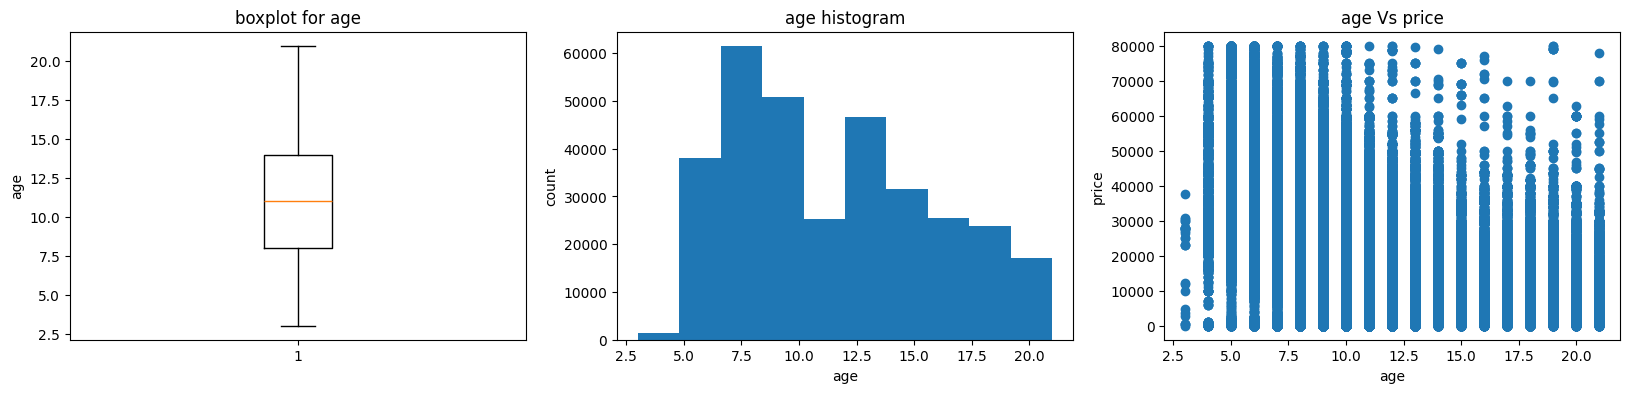

In [23]:
#plots to check outliers for age
prac2app_utils.subplot_box_hist_scatter(df, 'age', 'price', 'boxplot for age', 'age histogram', 'age Vs price')

<b>No outliers are observed for age </b>

#### Feature independence test for categorical variables

In [24]:
target = 'price'
cat_features = df.select_dtypes(include=['string']).columns
print(cat_features)

Index(['manufacturer', 'condition', 'cylinders', 'fuel', 'transmission',
       'drive', 'type', 'paint_color', 'state'],
      dtype='object')


In [25]:
#Anova Test for feature independence
for feature in cat_features:
    prac2app_utils.do_cat_cont_feature_independence_anova_test(df, feature, target)

manufacturer  is likely dependent
condition  is likely dependent
cylinders  is likely dependent
fuel  is likely dependent
transmission  is likely dependent
drive  is likely dependent
type  is likely dependent
paint_color  is likely dependent
state  is likely dependent


<b> Since all categorical features are likely dependent, I am going to manually do a feature selection for categorical variables. </b>

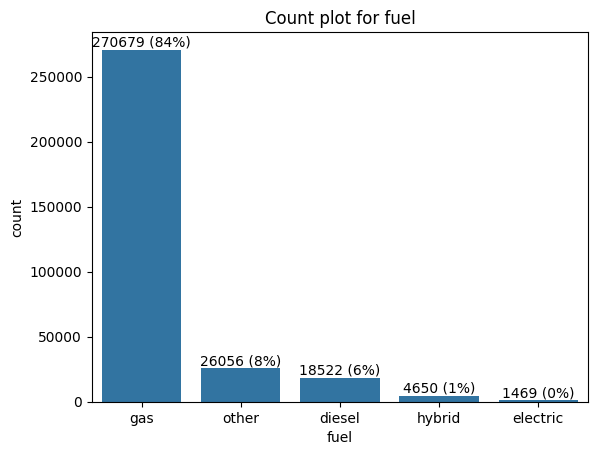

In [26]:
prac2app_utils.pretty_value_count_plot(df, 'fuel','Count plot for fuel')

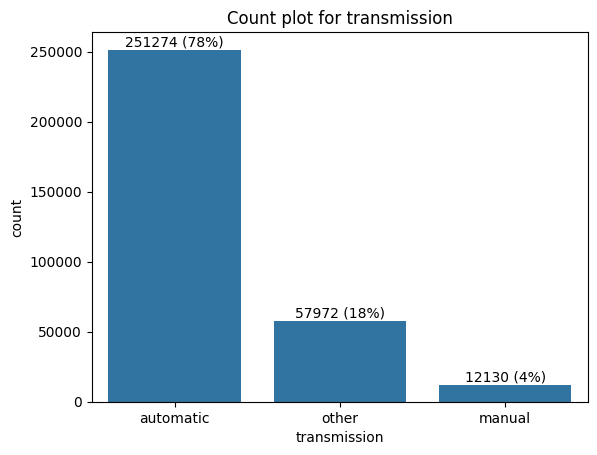

In [27]:
prac2app_utils.pretty_value_count_plot(df, 'transmission','Count plot for transmission')

#### Manual Feature Selection
1. Skip fuel as 84% of entries use gas fuelled vehicle
2. Skip transmission as 78% of the vehicle is automatic.
3. Skip cylinder as this info can be reasonably deduced from the type of vehicle

Typically,  car buyers look at the <b>combination</b> of manufacturer, condition, type, drive, odometer and the age of the car for making decisions about buying a car. State is also a factor as taxes and  dealer fees are different for different states.



In [28]:
numerical_features = ['odometer', 'age']
categorical_features = ['manufacturer', 'condition', 'type', 'drive', 'state']
features = ['odometer', 'age', 'manufacturer', 'condition', 'type', 'drive', 'state']

#### Encode categorical features using James Stein Encoding

I am using James Stein encoder to ensure that the number of features are manageable. Column transformers are used in the Modeling section to use JamesStein encoder to encode categorical variables.

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

#### Modeling Details

1. Build four models - Linear, Ridge, Lasso and GridCVSearch
2. Do simple cross validation for polynomial degrees [1,2,3] for Linear, Ridge and Lasso Regressions
3. Use Root Mean Squared Error as an evaluation metric for all these models. RMSE carries the same unit as the target variable which makes it easy to evaluate these models.

In [29]:
# features and target variables for train and test datasets
y = df['price']
X = df.drop(['price'], axis=1)
X = X[features]

In [30]:
X.columns

Index(['odometer', 'age', 'manufacturer', 'condition', 'type', 'drive',
       'state'],
      dtype='object')

In [31]:
# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 32)


In [32]:
# dataframe to keep track of model scores
best_models_df = pd.DataFrame(columns=['ModelName', 'RMSEScore', 'PolynomialDegree', 'PipelineObject'])

In [33]:

#simple cross validation to compare RMSE across different polynomial degrees
def simple_cross_validation_for_polynomial_regression(reg_type, max_poly_degree=8, debug=0):
    np.random.seed(42)
    train_rmses = []
    test_rmses = []
    models = []
    rmse_residuals = []
    train_residuals = []
    test_residuals = []
    if(reg_type != 'Linear' and reg_type != 'Ridge' and reg_type != 'Lasso'):
        print("Error - Invalid regression type. It must be either Linear or Ridge")
        return train_rmses, test_rmses, models
    #for degree in 1 - 5
    for i in range(1, max_poly_degree):
        col_transformer = make_column_transformer(
            (PolynomialFeatures(degree = i, include_bias = False), numerical_features),
            (JamesSteinEncoder(), ['manufacturer', 'condition', 'type', 'drive', 'state']))
        
        if(reg_type == 'Linear'):
            pipe = Pipeline([
                ('transformer',col_transformer),
                ('scaler', StandardScaler()),
                ('sfs', SequentialFeatureSelector(LinearRegression() ,n_features_to_select=5, scoring='neg_root_mean_squared_error')),
                ('reg', LinearRegression())
            ])
        elif(reg_type == 'Ridge'):
            pipe = Pipeline([
                ('transformer',col_transformer),
                ('scaler', StandardScaler()),
                ('reg', Ridge())
            ])
        else:
            pipe = Pipeline([
                ('transformer',col_transformer),
                ('scaler', StandardScaler()),
                ('reg', Lasso())
            ])
        pipe.fit(X_train[features], y_train)
        pred_train = pipe.predict(X_train[features])
        pred_test = pipe.predict(X_test[features])
        models.append(pipe)
        train_rmse = root_mean_squared_error(pred_train, y_train)
        test_rmse = root_mean_squared_error(pred_test, y_test)
        train_rmses.append(train_rmse)
        test_rmses.append(test_rmse)
        rmse_residuals.append(test_rmse - train_rmse)
        train_residuals.append(y_train-pred_train)
        test_residuals.append(y_test-pred_test)

        if(reg_type == 'Linear'):
            pipe_feature_names = pipe.named_steps['transformer'].get_feature_names_out()
            pipe_sfs_feature_indices = pipe.named_steps['sfs'].get_support(indices=True)
            final_sfs_feature_names = [pipe_feature_names[pipe_sfs_feature_indices[i]] for i in range(len(pipe_sfs_feature_indices))]
            if(debug):
                print(" feature names:", final_sfs_feature_names)
        print("Polynomial:",i,"train rmse:", train_rmse, " test rmse:", test_rmse)
        if(debug):
            print("Polynomial coefs:", pipe.named_steps['reg'].coef_, " intercept:", pipe.named_steps['reg'].intercept_)

    print(train_rmses)
    print(test_rmses)
    print(rmse_residuals)
    best_rmse = min(test_rmses)
    best_complexity = test_rmses.index(best_rmse)+1
    best_model = models[test_rmses.index(best_rmse)]
    print(f'The best degree polynomial model is:  {best_complexity}')
    print(f'The smallest root mean squared error on the test data is : {best_rmse: .2f}')

    #For Linear regression, feature names will be decided by SequentialFeatureSelector
    if(reg_type != 'Linear'):
        print("Best Model ", reg_type , " Regression Params:", best_model.named_steps['transformer'].get_feature_names_out())
        best_model_features = best_model.named_steps['transformer'].get_feature_names_out()
    
    if(reg_type == 'Linear'):
        if(debug):
            print("Best Model ", reg_type , " SFS Params:", best_model.named_steps['sfs'].get_feature_names_out())
            print("Best Model ", reg_type , " SFS Indices:", best_model.named_steps['sfs'].get_support(indices=True))
        fnames = best_model.named_steps['transformer'].get_feature_names_out()
        sfs_fname_indices = best_model.named_steps['sfs'].get_support(indices=True)
        sfs_feature_names = [fnames[sfs_fname_indices[i]]  for i in range(len(sfs_fname_indices))]
        print("Best Model ", reg_type , " Regression Params (SFS Feature Names):", sfs_feature_names)
        best_model_features = sfs_feature_names
        
    print("Best Model ", reg_type , " Regression coefs", best_model.named_steps['reg'].coef_)
    print("Best Model ", reg_type , " Regression intercept", best_model.named_steps['reg'].intercept_)
    best_features_df = pd.DataFrame({'Features':best_model_features,'Coefficients':best_model.named_steps['reg'].coef_})
    print( "Best Features and Coeeficients\n\n", best_features_df.to_markdown())
   
    
    
    
    return pred_train, pred_test, train_rmses, test_rmses, models, rmse_residuals, train_residuals, test_residuals, best_features_df

#### Linear Regression:

<b>Evaluation Metric: Root Mean Squared Error </b>

Cross validate Ridge regression across (1,2,3) degrees of polynomial and choose the model with the lease RMSE. 

In [34]:
#Linear Regression
max_poly_degree = 4
pred_train, pred_test, train_rmses, test_rmses =  ([] for i in range(4))
models, rmse_residuals, train_residuals, test_residuals = ([] for i in range(4))
pred_train, pred_test, train_rmses, test_rmses, models, rmse_residuals, train_residuals, test_residuals, lin_reg_best_model_features = simple_cross_validation_for_polynomial_regression('Linear', max_poly_degree)


Polynomial: 1 train rmse: 9129.209193700994  test rmse: 9093.951979850159
Polynomial: 2 train rmse: 9129.209193700994  test rmse: 9093.951979850159
Polynomial: 3 train rmse: 9129.209193700994  test rmse: 9093.951979850159
[9129.209193700994, 9129.209193700994, 9129.209193700994]
[9093.951979850159, 9093.951979850159, 9093.951979850159]
[-35.25721385083489, -35.25721385083489, -35.25721385083489]
The best degree polynomial model is:  1
The smallest root mean squared error on the test data is :  9093.95
Best Model  Linear  Regression Params (SFS Feature Names): ['polynomialfeatures__odometer', 'polynomialfeatures__age', 'jamessteinencoder__manufacturer', 'jamessteinencoder__type', 'jamessteinencoder__drive']
Best Model  Linear  Regression coefs [-2976.06698746 -5659.39108669  2550.84450497  3126.88461902
  2477.94889327]
Best Model  Linear  Regression intercept 19796.050972849076
Best Features and Coeeficients

 |    | Features                        |   Coefficients |
|---:|:-----------

#### Linear Regression Interpretation

After simple cross validation across polynomial degrees (1,2,3), the model with polynomial degree 1 has the least RMSE score. Cross validation across (1,2,3) degrees of polynomial test is returning the same train and test rmses. This is due to SequenceFeatureSelector selecting the same columns for Linear Regression of all 3 polynomial degrees.

 <b>Evaluation Metric: Best RMSE for test set is 9093.95198 </b>


 |    | Features                        |   Coefficients |
|---:|:--------------------------------|---------------:|
|  0 | polynomialfeatures__odometer    |       -2976.07 |
|  1 | polynomialfeatures__age         |       -5659.39 |
|  2 | jamessteinencoder__manufacturer |        2550.84 |
|  3 | jamessteinencoder__type         |        3126.88 |
|  4 | jamessteinencoder__drive        |        2477.95 |

Based on observed coefficients, I see that (manufacturer, type and drive) of the car seems to proportionately affect the price of the car. odometer and age shows a negative relationship which shows that older the car, lesser the price and vice versa.

In [35]:
#keep track of the LinearRegression model with the least RMSE in best_models_df
best_rmse = min(test_rmses)
best_lin_reg_rmse = min(test_rmses)
best_lin_reg_complexity = test_rmses.index(best_rmse)+1
best_lin_reg_model = models[test_rmses.index(best_rmse)]

best_lin_reg_model_df = pd.DataFrame({'ModelName':['LinearRegression'], 'RMSEScore':[best_lin_reg_rmse], 
                                      'PolynomialDegree': [best_lin_reg_complexity], 
                                      'PipelineObject':[best_lin_reg_model]}, index = [0])
best_models_df = pd.concat([best_models_df, best_lin_reg_model_df])


The polynomial degree that minimized Test Error was: 1


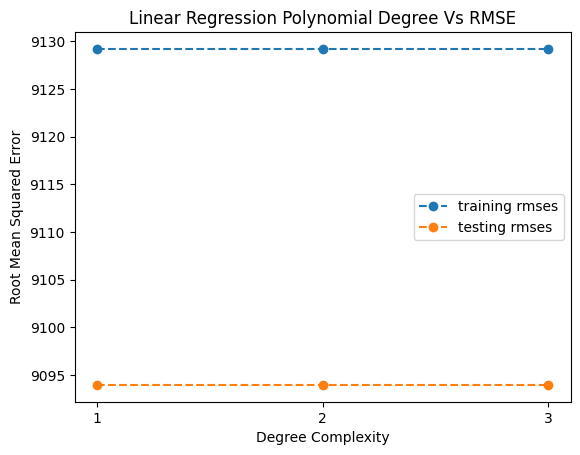

In [36]:
print(f'The polynomial degree that minimized Test Error was: {test_rmses.index(min(test_rmses)) + 1}')
plt.plot(range(1, max_poly_degree), train_rmses, '--o', label = 'training rmses')
plt.plot(range(1, max_poly_degree), test_rmses, '--o', label = 'testing rmses')
plt.xticks(range(1, max_poly_degree), range(1, max_poly_degree))
plt.xlabel('Degree Complexity')
plt.ylabel('Root Mean Squared Error')
plt.title('Linear Regression Polynomial Degree Vs RMSE')
plt.legend();

#### Ridge Regression:

<b>Evaluation Metric: Root Mean Squared Error </b>

Cross validate Ridge regression across (1,2,3) degrees of polynomial and choose the model with the lease RMSE. 

In [37]:
#Ridge Regression
pred_train, pred_test, train_rmses, test_rmses =  ([] for i in range(4))
models, rmse_residuals, train_residuals, test_residuals = ([] for i in range(4))
pred_train, pred_test, train_rmses, test_rmses, models, rmse_residuals, train_residuals, test_residuals, ridge_reg_best_model_features = simple_cross_validation_for_polynomial_regression('Ridge',max_poly_degree)


Polynomial: 1 train rmse: 9035.79018157268  test rmse: 9003.850156585038
Polynomial: 2 train rmse: 8917.523676616  test rmse: 8882.843897032057
Polynomial: 3 train rmse: 8910.794929523154  test rmse: 8876.502631028985
[9035.79018157268, 8917.523676616, 8910.794929523154]
[9003.850156585038, 8882.843897032057, 8876.502631028985]
[-31.940024987641664, -34.679779583942945, -34.29229849416879]
The best degree polynomial model is:  3
The smallest root mean squared error on the test data is :  8876.50
Best Model  Ridge  Regression Params: ['polynomialfeatures__odometer' 'polynomialfeatures__age'
 'polynomialfeatures__odometer^2' 'polynomialfeatures__odometer age'
 'polynomialfeatures__age^2' 'polynomialfeatures__odometer^3'
 'polynomialfeatures__odometer^2 age' 'polynomialfeatures__odometer age^2'
 'polynomialfeatures__age^3' 'jamessteinencoder__manufacturer'
 'jamessteinencoder__condition' 'jamessteinencoder__type'
 'jamessteinencoder__drive' 'jamessteinencoder__state']
Best Model  Ridge  R

In [38]:
#keep track of the RidgeRegression model with the least RMSE in best_models_df
best_ridge_reg_rmse = min(test_rmses)
best_ridge_reg_complexity = test_rmses.index(best_ridge_reg_rmse)+1
best_ridge_reg_model = models[test_rmses.index(best_ridge_reg_rmse)]

best_ridge_reg_model_df = pd.DataFrame({'ModelName':['RidgeRegression'], 'RMSEScore':[best_ridge_reg_rmse], 
                                      'PolynomialDegree': [best_ridge_reg_complexity], 
                                      'PipelineObject':[best_ridge_reg_model]}, index = [1])
best_models_df = pd.concat([best_models_df, best_ridge_reg_model_df])

### Ridge Regression Interpretation

After simple cross validation across polynomial degrees (1,2,3), the model with polynomial degree 3 has the least RMSE score. <br/>

 <b>Evaluation Metric: Best RMSE for polynomial degree 3 test set is 8876.502631 </b>

|    | Features                           |   Coefficients |
|---:|:-----------------------------------|---------------:|
|  0 | polynomialfeatures__odometer       |        238.842 |
|  1 | polynomialfeatures__age            |     -16562.8   |
|  2 | polynomialfeatures__odometer^2     |       4182     |
|  3 | polynomialfeatures__odometer age   |     -15246.7   |
|  4 | polynomialfeatures__age^2          |      20702     |
|  5 | polynomialfeatures__odometer^3     |       -137.201 |
|  6 | polynomialfeatures__odometer^2 age |      -2452.79  |
|  7 | polynomialfeatures__odometer age^2 |      11378.8   |
|  8 | polynomialfeatures__age^3          |      -9779.25  |
|  9 | jamessteinencoder__manufacturer    |       2499.77  |
| 10 | jamessteinencoder__condition       |        418.028 |
| 11 | jamessteinencoder__type            |       2934.12  |
| 12 | jamessteinencoder__drive           |       2472.08  |
| 13 | jamessteinencoder__state           |       1154.02  |

Based on observed coefficients, I see that (manufacturer, condition, type, drive and state ) of the car positively correlates with the price of the car. Age shows a negative relationship which shows that older the car, lesser the price and vice versa. It is surprising to see that the odometer doesn't have a negative coefficient.

The polynomial degree that minimized Test Error was: 3


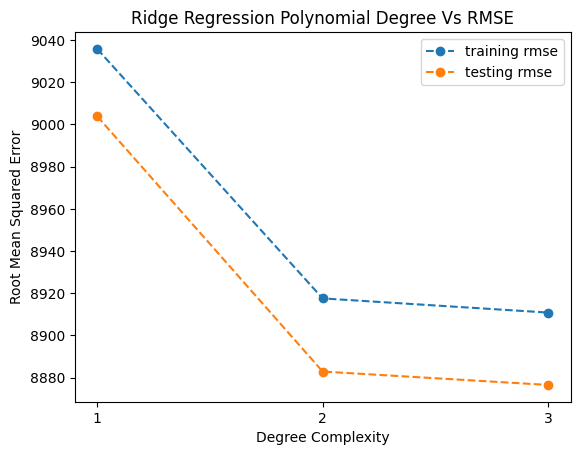

In [39]:
print(f'The polynomial degree that minimized Test Error was: {test_rmses.index(min(test_rmses)) + 1}')
plt.plot(range(1, max_poly_degree), train_rmses, '--o', label = 'training rmse')
plt.plot(range(1, max_poly_degree), test_rmses, '--o', label = 'testing rmse')
plt.xticks(range(1, max_poly_degree), range(1, max_poly_degree))
plt.xlabel('Degree Complexity')
plt.ylabel('Root Mean Squared Error')
plt.title('Ridge Regression Polynomial Degree Vs RMSE')
plt.legend();

#### Lasso Regression:

<b>Evaluation Metric: Root Mean Squared Error </b>

Cross validate Ridge regression across (1,2,3) degrees of polynomial and choose the model with the lease RMSE. 

In [40]:
#Lasso Regression
pred_train, pred_test, train_rmses, test_rmses =  ([] for i in range(4))
models, rmse_residuals, train_residuals, test_residuals = ([] for i in range(4))
pred_train, pred_test, train_rmses, test_rmses, models, rmse_residuals, train_residuals, test_residuals, lasso_reg_best_model_features  = simple_cross_validation_for_polynomial_regression('Lasso', max_poly_degree)

Polynomial: 1 train rmse: 9035.790385789747  test rmse: 9003.8406418615
Polynomial: 2 train rmse: 8917.542014760602  test rmse: 8882.821391187304
Polynomial: 3 train rmse: 8916.120371521572  test rmse: 8881.619973397464
[9035.790385789747, 8917.542014760602, 8916.120371521572]
[9003.8406418615, 8882.821391187304, 8881.619973397464]
[-31.9497439282477, -34.720623573297416, -34.50039812410796]
The best degree polynomial model is:  3
The smallest root mean squared error on the test data is :  8881.62
Best Model  Lasso  Regression Params: ['polynomialfeatures__odometer' 'polynomialfeatures__age'
 'polynomialfeatures__odometer^2' 'polynomialfeatures__odometer age'
 'polynomialfeatures__age^2' 'polynomialfeatures__odometer^3'
 'polynomialfeatures__odometer^2 age' 'polynomialfeatures__odometer age^2'
 'polynomialfeatures__age^3' 'jamessteinencoder__manufacturer'
 'jamessteinencoder__condition' 'jamessteinencoder__type'
 'jamessteinencoder__drive' 'jamessteinencoder__state']
Best Model  Lasso 

In [41]:
#keep track of the LassoRegression model with the least RMSE in best_models_df

best_lasso_reg_rmse = min(test_rmses)
best_lasso_reg_complexity = test_rmses.index(best_lasso_reg_rmse)+1
best_lasso_reg_model = models[test_rmses.index(best_lasso_reg_rmse)]

best_lasso_reg_model_df = pd.DataFrame({'ModelName':['LassoRegression'], 'RMSEScore':[best_lasso_reg_rmse], 
                                      'PolynomialDegree': [best_lasso_reg_complexity], 
                                      'PipelineObject':[best_lasso_reg_model]}, index = [2])
best_models_df = pd.concat([best_models_df, best_lasso_reg_model_df])


#### Lasso Regression Interpretation

After simple cross validation across polynomial degrees (1,2,3), model with polynomial degree 3 has the least RMSE score. <br/>

 <b>Evaluation Metric: Best RMSE for polynomial degree 3 test set is 8881.619973   </b>


|    | Features                           |   Coefficients |
|---:|:-----------------------------------|---------------:|
|  0 | polynomialfeatures__odometer       |      -3540.1   |
|  1 | polynomialfeatures__age            |     -10693.4   |
|  2 | polynomialfeatures__odometer^2     |       2343.2   |
|  3 | polynomialfeatures__odometer age   |      -2151.64  |
|  4 | polynomialfeatures__age^2          |       3958.17  |
|  5 | polynomialfeatures__odometer^3     |        190.569 |
|  6 | polynomialfeatures__odometer^2 age |      -1198.49  |
|  7 | polynomialfeatures__odometer age^2 |       1891.68  |
|  8 | polynomialfeatures__age^3          |       1327.9   |
|  9 | jamessteinencoder__manufacturer    |       2499.81  |
| 10 | jamessteinencoder__condition       |        413.916 |
| 11 | jamessteinencoder__type            |       2943.58  |
| 12 | jamessteinencoder__drive           |       2474.49  |
| 13 | jamessteinencoder__state           |       1155.83  |

Based on observed coefficients, I see that (manufacturer, condition, type, drive, state ) of the car positively correlates with the price of the car. odometer and age shows a negative relationship which shows that older the car, lesser the price and vice versa.

The polynomial degree that minimized Test Error was: 3


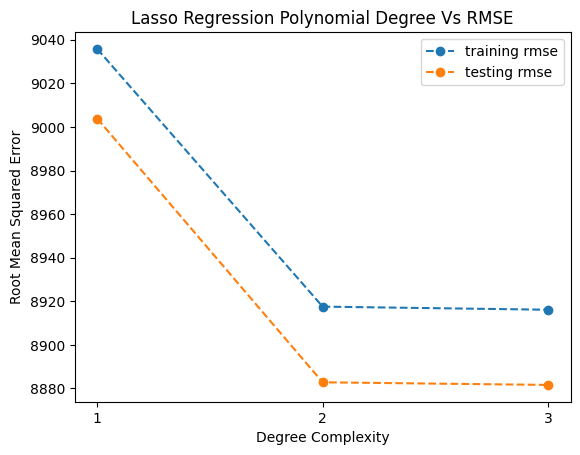

In [42]:
print(f'The polynomial degree that minimized Test Error was: {test_rmses.index(min(test_rmses)) + 1}')
plt.plot(range(1, max_poly_degree), train_rmses, '--o', label = 'training rmse')
plt.plot(range(1, max_poly_degree), test_rmses, '--o', label = 'testing rmse')
plt.xticks(range(1, max_poly_degree), range(1, max_poly_degree))
plt.xlabel('Degree Complexity')
plt.ylabel('Root Mean Squared Error')
plt.title('Lasso Regression Polynomial Degree Vs RMSE')
plt.legend();

#### GridCVSearch 

<b>Evaluation Metric: Root Mean Squared Error.

Use Ridge regression and a polynomial degree of 3 along with 5 fold cross validation. Do hyperparameter selection by iterating over alpha for the ridge regression. 

In [43]:
grid_cv_search_poly_degree = 3
col_transformer = make_column_transformer(
            (PolynomialFeatures( degree = grid_cv_search_poly_degree, include_bias = False), numerical_features),
            ((JamesSteinEncoder(), ['manufacturer', 'condition', 'type', 'drive', 'state']))
)

pipe = Pipeline([
                ('transformer',col_transformer),
                ('scaler', StandardScaler()),
                ('ridge', Ridge())
])

In [44]:

# Grid search parameters
param_grid = [    
{"ridge__alpha": [0.001, 0.01, 0.1,1, 10]}  # Ridge regularization parameter 
]
# Create GridSearchCV object
grid_search = GridSearchCV(
    estimator=pipe, 
    param_grid=param_grid, 
    cv=5,  # 5-fold cross validation
    scoring="neg_root_mean_squared_error", 
    n_jobs=-1  # Use all available cores
)

# Fit the grid search
grid_search.fit(X_train[features], y_train)

# Print best parameters
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")


# Use the best model on test data
best_model = grid_search.best_estimator_


Best parameters: {'ridge__alpha': 0.1}
Best Score: -8913.213270988472


In [45]:
# Print best parameters
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")
print(f"Best scorer: {grid_search.scorer_}")



Best parameters: {'ridge__alpha': 0.1}
Best Score: -8913.213270988472
Best scorer: make_scorer(root_mean_squared_error, greater_is_better=False, response_method='predict')


In [46]:
print(grid_search.cv_results_)

{'mean_fit_time': array([2.4467011 , 2.57014942, 2.40643773, 2.26870551, 2.01536417]), 'std_fit_time': array([0.05189118, 0.03001143, 0.19794598, 0.01944147, 0.40718834]), 'mean_score_time': array([0.33586087, 0.26614337, 0.24255323, 0.20149436, 0.12294221]), 'std_score_time': array([0.01749012, 0.0172317 , 0.02435239, 0.04074685, 0.01710528]), 'param_ridge__alpha': masked_array(data=[0.001, 0.01, 0.1, 1.0, 10.0],
             mask=[False, False, False, False, False],
       fill_value=1e+20), 'params': [{'ridge__alpha': 0.001}, {'ridge__alpha': 0.01}, {'ridge__alpha': 0.1}, {'ridge__alpha': 1}, {'ridge__alpha': 10}], 'split0_test_score': array([-8920.53523401, -8920.53641423, -8920.54831744, -8920.67613524,
       -8922.17091717]), 'split1_test_score': array([-8914.75872471, -8914.75959819, -8914.7684407 , -8914.86635923,
       -8916.13798817]), 'split2_test_score': array([-8926.73102351, -8926.73008044, -8926.72087439, -8926.64927919,
       -8926.88403042]), 'split3_test_score': ar

In [47]:
best_model_features = best_model.named_steps['transformer'].get_feature_names_out()
best_gridcvsearch_features = pd.DataFrame({'Features':best_model_features,'Coefficients':best_model.named_steps['ridge'].coef_})
print( "Best Features and Coefficients\n\n", best_gridcvsearch_features.to_markdown())
   

Best Features and Coefficients

 |    | Features                           |   Coefficients |
|---:|:-----------------------------------|---------------:|
|  0 | polynomialfeatures__odometer       |        397.433 |
|  1 | polynomialfeatures__age            |     -16907.5   |
|  2 | polynomialfeatures__odometer^2     |       4218.6   |
|  3 | polynomialfeatures__odometer age   |     -15734.7   |
|  4 | polynomialfeatures__age^2          |      21588.9   |
|  5 | polynomialfeatures__odometer^3     |       -145.471 |
|  6 | polynomialfeatures__odometer^2 age |      -2471.57  |
|  7 | polynomialfeatures__odometer age^2 |      11710.6   |
|  8 | polynomialfeatures__age^3          |     -10328.3   |
|  9 | jamessteinencoder__manufacturer    |       2499.98  |
| 10 | jamessteinencoder__condition       |        418.259 |
| 11 | jamessteinencoder__type            |       2933.86  |
| 12 | jamessteinencoder__drive           |       2471.94  |
| 13 | jamessteinencoder__state           |       11

In [48]:

best_lin_reg_model_df = pd.DataFrame({'ModelName':['RidgeGridCVSearch'], 'RMSEScore':[abs(grid_search.best_score_)], 
                                      'PolynomialDegree': [grid_cv_search_poly_degree], 
                                      'PipelineObject':[grid_search.best_estimator_]}, index = [3])
best_models_df = pd.concat([best_models_df, best_lin_reg_model_df])



#### GridCVSearch Interpretation

With GridCVSearch for RidgeRegression, the optimal value for the hyperparameter alpha is 0.1 with the RMSE score of 8913.213270988472 for polynomial degree 3.

GridCVSearch also runs the K-Fold algorithm to find the best test set.

 |    | Features                           |   Coefficients |
|---:|:-----------------------------------|---------------:|
|  0 | polynomialfeatures__odometer       |        397.433 |
|  1 | polynomialfeatures__age            |     -16907.5   |
|  2 | polynomialfeatures__odometer^2     |       4218.6   |
|  3 | polynomialfeatures__odometer age   |     -15734.7   |
|  4 | polynomialfeatures__age^2          |      21588.9   |
|  5 | polynomialfeatures__odometer^3     |       -145.471 |
|  6 | polynomialfeatures__odometer^2 age |      -2471.57  |
|  7 | polynomialfeatures__odometer age^2 |      11710.6   |
|  8 | polynomialfeatures__age^3          |     -10328.3   |
|  9 | jamessteinencoder__manufacturer    |       2499.98  |
| 10 | jamessteinencoder__condition       |        418.259 |
| 11 | jamessteinencoder__type            |       2933.86  |
| 12 | jamessteinencoder__drive           |       2471.94  |
| 13 | jamessteinencoder__state           |       1153.97  |




Based on the coefficients, I see that (manufacturer, condition, type, drive abd state ) of the car positively correlates with the price of the car. Age shows a negative relationship which shows that older the car, lesser the price and vice versa. It is surprising to see that the odometer doesn't have a negative coefficient. The observation are similar to Ridge Regression results without GridCVSearch.

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [49]:
# consult the best_models_df for looking up the model with the least RMSE
print(best_models_df[['ModelName', 'RMSEScore', 'PolynomialDegree']].to_markdown())

|    | ModelName         |   RMSEScore |   PolynomialDegree |
|---:|:------------------|------------:|-------------------:|
|  0 | LinearRegression  |     9093.95 |                  1 |
|  1 | RidgeRegression   |     8876.5  |                  3 |
|  2 | LassoRegression   |     8881.62 |                  3 |
|  3 | RidgeGridCVSearch |     8913.21 |                  3 |


In [50]:
best_models_df['RMSEScore'].min()

np.float64(8876.502631028985)

#### Best Model Selection

|    | ModelName         |   RMSEScore |   PolynomialDegree |
|---:|:------------------|------------:|-------------------:|
|  0 | LinearRegression  |     9093.95 |                  1 |
|  1 | RidgeRegression   |     8876.5  |                  3 |
|  2 | LassoRegression   |     8881.62 |                  3 |
|  3 | RidgeGridCVSearch |     8913.21 |                  3 |

Based on RMSE scores of test sets, Ridge Regression has the least RMSE value and therefore is the best model.

Manufacturer, condition, type, drive and state of the car influence the car price significantly. Even though the odometer has a positive coefficient, I am skeptical of its positive correlation to the price. This requires further investigation.

I am not sure how to interpret odometer^2, odometer age, etc


### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

#### Findings

Based on our analysis, customers value (manufacturer, condition, type, drive) of the car. State of purchase affects the car price due to different taxation, dealership fees and other state specific fees.

As a future work, I would fine tune models by running  models on a state basis and also explore ways to use categorial variables such as <b>model</b> which has thousands of values.